In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import os
import subprocess
import numpy as np
import os
import subprocess
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

from src.utils.synthetic_seqdata import *
from src.utils.datasets import DNASequenceDataset
from src.models.deepbind_cnn import DeepBindCNN
from src.trainer import Trainer

In [3]:
# download and load the data
from src.utils.synthetic_seqdata import download_data, load_data
savedir = "./data"
# download_data(savedir)
Xs, Ys = load_data(savedir=savedir)

In [4]:
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [5]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": "deepbind",
    "dataset": "synthetic data",
    "epochs": 35,
    "patience": 3,
    }

In [6]:
# create datasets and data loaders
alphabet = "ACGT"
train_dataset = DNASequenceDataset(Xs["train"], Ys["train"], alphabet=alphabet)
valid_dataset = DNASequenceDataset(Xs["valid"], Ys["valid"], alphabet=alphabet)
test_dataset = DNASequenceDataset(Xs["test"], Ys["test"], alphabet=alphabet)

loaders = {
    'train': DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True),
    'valid': DataLoader(valid_dataset, batch_size=config['batch_size']),
    'test': DataLoader(test_dataset, batch_size=config['batch_size']),
}

In [7]:
len(loaders['train']), len(loaders['valid']), len(loaders['test'])

(438, 63, 125)

In [8]:
# import wandb
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="deepbind_cnn_synthetic1",
    
#     # track hyperparameters and run metadata
#     config=config
# )


In [9]:
# Prepare data and model
input_size = 4  # One-hot encoding of DNA bases A, C, G, T
output_size = 1  # Single output for regression, modify for multi-class classification
learning_rate = 0.001
num_epochs = 35
patience = 3  # Number of epochs to wait before early stopping
current_patience = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepBindCNN(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
print(model)

DeepBindCNN(
  (conv1): Conv1d(4, 16, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [11]:
trainer = Trainer(model, criterion, optimizer)

# fit model
history = trainer.fit(loaders['train'], val_loader=loaders['valid'], nepochs=config['epochs'])

Epoch:   1/35, loss: 0.3495, val_loss: 0.3305
Epoch:   2/35, loss: 0.2918, val_loss: 0.3342
Epoch:   3/35, loss: 0.2922, val_loss: 0.2672
Epoch:   4/35, loss: 0.3042, val_loss: 0.2561
Epoch:   5/35, loss: 0.2930, val_loss: 0.3333
Epoch:   6/35, loss: 0.2790, val_loss: 0.3051
Epoch:   7/35, loss: 0.3009, val_loss: 0.2510
Epoch:   8/35, loss: 0.3062, val_loss: 0.3126
Epoch:   9/35, loss: 0.2795, val_loss: 0.3248
Epoch:  10/35, loss: 0.2980, val_loss: 0.2558
Epoch:  11/35, loss: 0.3144, val_loss: 0.3100
Epoch:  12/35, loss: 0.2786, val_loss: 0.3292
Epoch:  13/35, loss: 0.3045, val_loss: 0.2526
Epoch:  14/35, loss: 0.3134, val_loss: 0.3299
Epoch:  15/35, loss: 0.2771, val_loss: 0.3160
Epoch:  16/35, loss: 0.3167, val_loss: 0.2509
Epoch:  17/35, loss: 0.3066, val_loss: 0.3588
Epoch:  18/35, loss: 0.2856, val_loss: 0.2866
Epoch:  19/35, loss: 0.3310, val_loss: 0.2753
Epoch:  20/35, loss: 0.2893, val_loss: 0.3658
Epoch:  21/35, loss: 0.3094, val_loss: 0.2520
Epoch:  22/35, loss: 0.3211, val_l

In [ ]:
# Training loop with validation
train_losses = []
valid_losses = []
# Training loop
for epoch in range(num_epochs):
    best_valid_loss = float('inf')
    train_loss = train(model, loaders['train'], criterion, optimizer)
    valid_loss = evaluate(model, loaders['valid'], criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    wandb.log({"train_loss": train_loss, "valid_loss": valid_loss})
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        current_patience = 0
        # Save the best model if you want
        torch.save(model.state_dict(), "best_model.pt")
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping! Validation loss hasn't improved in the last", patience, "epochs.")
            break

# Test the model on the test set
test_loss = evaluate(model, loaders['test'], criterion)
print(f"Test Loss: {test_loss:.4f}")


In [ ]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


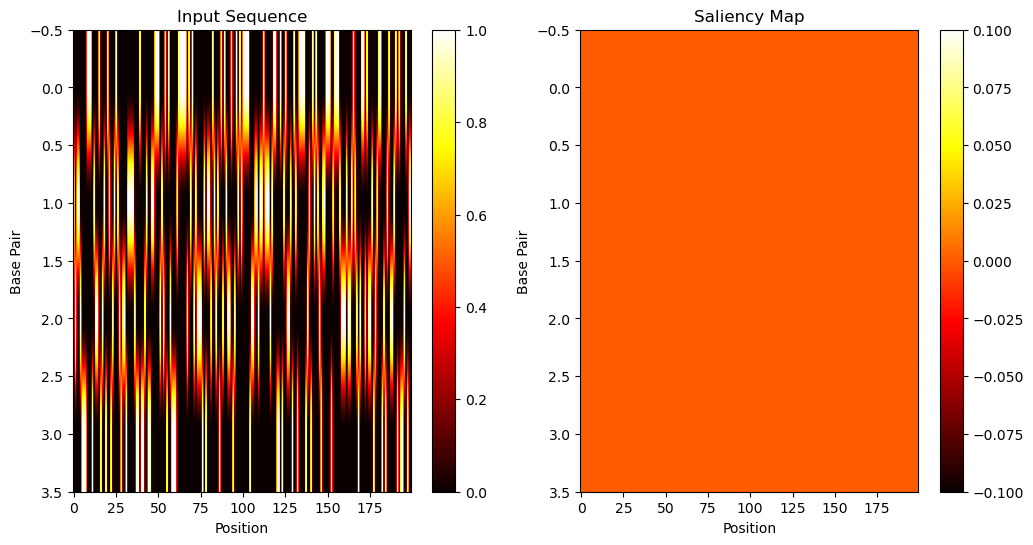

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Define the CNN model with dropout
# ... (Same code as before)

# Function to compute saliency maps
def compute_saliency_map(model, input_sequence, target_class, criterion):
    model.eval()
    input_sequence.requires_grad_()
    output = model(input_sequence)
    loss = criterion(output, target_class)
    loss.backward()

    saliency_map = input_sequence.grad.data.abs().squeeze().cpu().numpy()
    return saliency_map

# Usage example for computing saliency maps
# Assuming you have loaded the test dataset and the model is already trained

# Select a random sample from the test dataset
sample_index = np.random.randint(len(test_dataset))
input_sequence, target_label = test_dataset[sample_index]

# Reshape the input_sequence for model processing
input_sequence = input_sequence.unsqueeze(0).to(device)

# Compute the saliency map for the target label
saliency_map = compute_saliency_map(model, input_sequence, target_label, criterion)

# Plot the input sequence and its saliency map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Input Sequence")
plt.imshow(input_sequence.squeeze().cpu().detach().numpy(), cmap='hot', aspect='auto')
plt.xlabel("Position")
plt.ylabel("Base Pair")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap='hot', aspect='auto')
plt.xlabel("Position")
plt.ylabel("Base Pair")
plt.colorbar()

plt.show()
